# 圖片分類

In [1]:
import os
import shutil

# 建立目標資料夾
if not os.path.exists('./my_images'):
    os.mkdir('./my_images')

# 遍歷資料夾中的檔案
for filename in os.listdir('./hiragana_images'):
    # 判斷檔案是否為 jpg 檔
    if filename.endswith('.jpg'):
        # 取得檔名中的非數字字元
        class_name = os.path.splitext(''.join(filter(lambda x: not x.isdigit(), filename)))[0]
        # 建立目標資料夾
        target_folder = os.path.join('./my_images', class_name)
        if not os.path.exists(target_folder):
            os.mkdir(target_folder)
        # 複製檔案到對應的資料夾中
        shutil.copy(os.path.join('./hiragana_images', filename), os.path.join(target_folder, filename))


# 模型訓練

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# 超參數

num_classes = 50  # 50音分類
batch_size = 20  #訓練樣本數
num_epochs = 30  #一期訓練  Iteration = （Data set size / Batch size）* Epoch = (1000/20)*10 = 5000
learning_rate = 0.001 #學習率

In [4]:
# 數據預處理
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 調整大小為 32x32
    transforms.Grayscale(num_output_channels=1),  # 轉為單通道灰度圖像
    transforms.ToTensor()  # 轉為張量
])

In [5]:
# 載入數據 並將數據分配測試集和訓練集 8:2
train_dataset = datasets.ImageFolder(root='./my_images', transform=transform) # datasets.ImageFolder 會將資料夾中的圖片依照資料夾名稱分類
train_data, test_data = train_test_split(train_dataset, test_size=0.2, random_state=42) #train_test_split 會將資料分成兩部分，一部分用來訓練，一部分用來測試
#訓練集
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)  #每次訓練數量 = Data set size(*0.8) / Batch size = 800/20 = 40
#測試集
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # 載入數據
# train_dataset = datasets.ImageFolder(root='F:\pycharm_pro\pytorch_learn\my_images', transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [6]:
# 定義模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
            nn.Linear(4*4*128, 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, 50)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out



In [7]:
# 實例化模型、損失函數和優化器
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#可視化模型
from torchsummary import summary
summary(model, input_size=(1, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                  [-1, 256]         524,544
          Dropout-14                  [

In [8]:
# 訓練模型
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 前向傳播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], \
                    Step [{i+1}/{total_step}], \
                    Loss: {loss.item():.4f}')


Epoch [1/30],                     Step [10/40],                     Loss: 3.6558
Epoch [1/30],                     Step [20/40],                     Loss: 3.2927
Epoch [1/30],                     Step [30/40],                     Loss: 2.7561
Epoch [1/30],                     Step [40/40],                     Loss: 1.9224
Epoch [2/30],                     Step [10/40],                     Loss: 1.2578
Epoch [2/30],                     Step [20/40],                     Loss: 1.2346
Epoch [2/30],                     Step [30/40],                     Loss: 0.9538
Epoch [2/30],                     Step [40/40],                     Loss: 0.6365
Epoch [3/30],                     Step [10/40],                     Loss: 0.3602
Epoch [3/30],                     Step [20/40],                     Loss: 0.3572
Epoch [3/30],                     Step [30/40],                     Loss: 0.1810
Epoch [3/30],                     Step [40/40],                     Loss: 0.1607
Epoch [4/30],               

In [9]:
# 測試模型
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Accuracy of the model on the test images: 98.5 %


In [10]:
# 保存模型
torch.save(model.state_dict(), '50on_model.ckpt')

# 手寫測試

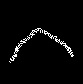

預測結果:kanaHE


In [11]:
from PIL import Image
# 轉換圖片
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 調整大小為 32x32
    transforms.Grayscale(num_output_channels=1),  # 轉為單通道灰度圖像
    transforms.ToTensor()  # 轉為張量
])

# 載入圖片
img = Image.open('./test_images/HE.jpg')
display(img)
img = test_transform(img)


# 增加一維，批次大小設為 1
img = img.unsqueeze(0)

# 使用訓練好的模型進行預測
model.eval()
with torch.no_grad():
    output = model(img)
    pred = output.argmax(dim=1)


label_dict = train_dataset.class_to_idx
reverse_label_dict = {v: k for k, v in label_dict.items()}
print(f'預測結果:{reverse_label_dict[pred.item()]}')
